In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
# import dataset
df = pd.read_csv("GE.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-03-09,8.33,8.66,8.11,8.21,8.170634,122400700
1,2020-03-10,8.78,8.85,8.16,8.85,8.807567,98938900
2,2020-03-11,8.62,8.66,8.16,8.21,8.170634,103402500
3,2020-03-12,7.23,7.78,6.83,7.23,7.195333,157416100
4,2020-03-13,7.80,8.04,7.19,7.85,7.812360,110144600


In [47]:
df.shape

(253, 7)

In [7]:
type(df['Date'])

pandas.core.series.Series

In [8]:
# separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])

In [9]:
train_dates

0     2020-03-09
1     2020-03-10
2     2020-03-11
3     2020-03-12
4     2020-03-13
         ...    
248   2021-03-03
249   2021-03-04
250   2021-03-05
251   2021-03-08
252   2021-03-09
Name: Date, Length: 253, dtype: datetime64[ns]

In [20]:
# variable for training
cols = list(df)[1:6]
# cols = list(df.columns)[1:6]

In [21]:
list(df.columns)[1:6]

['Open', 'High', 'Low', 'Close', 'Adj Close']

In [22]:
list(df)

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [28]:
df[cols].info()#.astype('float')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       253 non-null    float64
 1   High       253 non-null    float64
 2   Low        253 non-null    float64
 3   Close      253 non-null    float64
 4   Adj Close  253 non-null    float64
dtypes: float64(5)
memory usage: 10.0 KB


<AxesSubplot:>

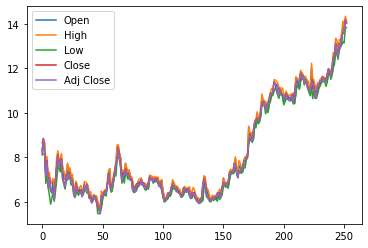

In [29]:
df_for_training = df[cols].astype('float')
df_for_plot = df_for_training.tail(5000)
df_for_plot.plot.line()

In [34]:
# LSTM use sigmoid and  tanh that are sensitive to magnitude.So values should to be normalized

scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [36]:
# In LSTM we reshape data into n_sample(batch_size), time_steps, features(dimensions)

trainX  = []
trainY  = []

n_future = 1  # No  of days we want to  predict into future
n_past = 14   # No. of past days we want use to predict the future

for i in range(n_past, len(df_for_training_scaled)- n_future +1) :
    trainX.append(df_for_training_scaled[i-n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_past -1 :i +n_future, 0])

In [42]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [45]:
print("trainX shape: {} \nand trainY shape: {}".format(trainX.shape, trainY.shape))

trainX shape: (239, 14, 5) 
and trainY shape: (239, 0)


In [48]:
trainY

array([], shape=(239, 0), dtype=float64)

In [46]:
# Define Model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences = True))
model.add(LSTM(32, activation='relu', return_sequences = False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 0)                 0         
Total params: 30,336
Trainable params: 30,336
Non-trainable params: 0
_________________________________________________________________


In [49]:
# fit model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=2)

Epoch 1/10
14/14 - 3s - loss: nan - val_loss: nan
Epoch 2/10
14/14 - 0s - loss: nan - val_loss: nan
Epoch 3/10
14/14 - 0s - loss: nan - val_loss: nan
Epoch 4/10
14/14 - 0s - loss: nan - val_loss: nan
Epoch 5/10
14/14 - 0s - loss: nan - val_loss: nan
Epoch 6/10
14/14 - 0s - loss: nan - val_loss: nan
Epoch 7/10
14/14 - 0s - loss: nan - val_loss: nan
Epoch 8/10
14/14 - 0s - loss: nan - val_loss: nan
Epoch 9/10
14/14 - 0s - loss: nan - val_loss: nan
Epoch 10/10
14/14 - 0s - loss: nan - val_loss: nan


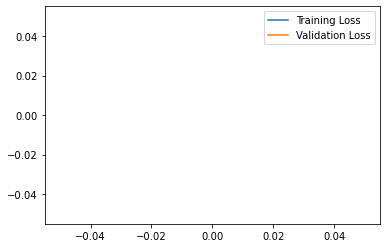

In [50]:
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()

In [53]:
# Forecasting 
# Start with the last day in training date, and predict future

n_future = 90 # No. of days we want to predict
forecast_perioid_dates = pd.date_range(list(train_dates), periods=n_future,freq='1d').tolist()
forecast = model.predict(trainX[-n_future:])

# performe inverse scalling to get back original data to plot
forcast_copies = np.repeat(forecast, df_for_training.shape[1], axis=1)
y_pred_future = scaler.inverse_transform(forcast_copies)[:, 0]

TypeError: Cannot convert input [[Timestamp('2020-03-09 00:00:00'), Timestamp('2020-03-10 00:00:00'), Timestamp('2020-03-11 00:00:00'), Timestamp('2020-03-12 00:00:00'), Timestamp('2020-03-13 00:00:00'), Timestamp('2020-03-16 00:00:00'), Timestamp('2020-03-17 00:00:00'), Timestamp('2020-03-18 00:00:00'), Timestamp('2020-03-19 00:00:00'), Timestamp('2020-03-20 00:00:00'), Timestamp('2020-03-23 00:00:00'), Timestamp('2020-03-24 00:00:00'), Timestamp('2020-03-25 00:00:00'), Timestamp('2020-03-26 00:00:00'), Timestamp('2020-03-27 00:00:00'), Timestamp('2020-03-30 00:00:00'), Timestamp('2020-03-31 00:00:00'), Timestamp('2020-04-01 00:00:00'), Timestamp('2020-04-02 00:00:00'), Timestamp('2020-04-03 00:00:00'), Timestamp('2020-04-06 00:00:00'), Timestamp('2020-04-07 00:00:00'), Timestamp('2020-04-08 00:00:00'), Timestamp('2020-04-09 00:00:00'), Timestamp('2020-04-13 00:00:00'), Timestamp('2020-04-14 00:00:00'), Timestamp('2020-04-15 00:00:00'), Timestamp('2020-04-16 00:00:00'), Timestamp('2020-04-17 00:00:00'), Timestamp('2020-04-20 00:00:00'), Timestamp('2020-04-21 00:00:00'), Timestamp('2020-04-22 00:00:00'), Timestamp('2020-04-23 00:00:00'), Timestamp('2020-04-24 00:00:00'), Timestamp('2020-04-27 00:00:00'), Timestamp('2020-04-28 00:00:00'), Timestamp('2020-04-29 00:00:00'), Timestamp('2020-04-30 00:00:00'), Timestamp('2020-05-01 00:00:00'), Timestamp('2020-05-04 00:00:00'), Timestamp('2020-05-05 00:00:00'), Timestamp('2020-05-06 00:00:00'), Timestamp('2020-05-07 00:00:00'), Timestamp('2020-05-08 00:00:00'), Timestamp('2020-05-11 00:00:00'), Timestamp('2020-05-12 00:00:00'), Timestamp('2020-05-13 00:00:00'), Timestamp('2020-05-14 00:00:00'), Timestamp('2020-05-15 00:00:00'), Timestamp('2020-05-18 00:00:00'), Timestamp('2020-05-19 00:00:00'), Timestamp('2020-05-20 00:00:00'), Timestamp('2020-05-21 00:00:00'), Timestamp('2020-05-22 00:00:00'), Timestamp('2020-05-26 00:00:00'), Timestamp('2020-05-27 00:00:00'), Timestamp('2020-05-28 00:00:00'), Timestamp('2020-05-29 00:00:00'), Timestamp('2020-06-01 00:00:00'), Timestamp('2020-06-02 00:00:00'), Timestamp('2020-06-03 00:00:00'), Timestamp('2020-06-04 00:00:00'), Timestamp('2020-06-05 00:00:00'), Timestamp('2020-06-08 00:00:00'), Timestamp('2020-06-09 00:00:00'), Timestamp('2020-06-10 00:00:00'), Timestamp('2020-06-11 00:00:00'), Timestamp('2020-06-12 00:00:00'), Timestamp('2020-06-15 00:00:00'), Timestamp('2020-06-16 00:00:00'), Timestamp('2020-06-17 00:00:00'), Timestamp('2020-06-18 00:00:00'), Timestamp('2020-06-19 00:00:00'), Timestamp('2020-06-22 00:00:00'), Timestamp('2020-06-23 00:00:00'), Timestamp('2020-06-24 00:00:00'), Timestamp('2020-06-25 00:00:00'), Timestamp('2020-06-26 00:00:00'), Timestamp('2020-06-29 00:00:00'), Timestamp('2020-06-30 00:00:00'), Timestamp('2020-07-01 00:00:00'), Timestamp('2020-07-02 00:00:00'), Timestamp('2020-07-06 00:00:00'), Timestamp('2020-07-07 00:00:00'), Timestamp('2020-07-08 00:00:00'), Timestamp('2020-07-09 00:00:00'), Timestamp('2020-07-10 00:00:00'), Timestamp('2020-07-13 00:00:00'), Timestamp('2020-07-14 00:00:00'), Timestamp('2020-07-15 00:00:00'), Timestamp('2020-07-16 00:00:00'), Timestamp('2020-07-17 00:00:00'), Timestamp('2020-07-20 00:00:00'), Timestamp('2020-07-21 00:00:00'), Timestamp('2020-07-22 00:00:00'), Timestamp('2020-07-23 00:00:00'), Timestamp('2020-07-24 00:00:00'), Timestamp('2020-07-27 00:00:00'), Timestamp('2020-07-28 00:00:00'), Timestamp('2020-07-29 00:00:00'), Timestamp('2020-07-30 00:00:00'), Timestamp('2020-07-31 00:00:00'), Timestamp('2020-08-03 00:00:00'), Timestamp('2020-08-04 00:00:00'), Timestamp('2020-08-05 00:00:00'), Timestamp('2020-08-06 00:00:00'), Timestamp('2020-08-07 00:00:00'), Timestamp('2020-08-10 00:00:00'), Timestamp('2020-08-11 00:00:00'), Timestamp('2020-08-12 00:00:00'), Timestamp('2020-08-13 00:00:00'), Timestamp('2020-08-14 00:00:00'), Timestamp('2020-08-17 00:00:00'), Timestamp('2020-08-18 00:00:00'), Timestamp('2020-08-19 00:00:00'), Timestamp('2020-08-20 00:00:00'), Timestamp('2020-08-21 00:00:00'), Timestamp('2020-08-24 00:00:00'), Timestamp('2020-08-25 00:00:00'), Timestamp('2020-08-26 00:00:00'), Timestamp('2020-08-27 00:00:00'), Timestamp('2020-08-28 00:00:00'), Timestamp('2020-08-31 00:00:00'), Timestamp('2020-09-01 00:00:00'), Timestamp('2020-09-02 00:00:00'), Timestamp('2020-09-03 00:00:00'), Timestamp('2020-09-04 00:00:00'), Timestamp('2020-09-08 00:00:00'), Timestamp('2020-09-09 00:00:00'), Timestamp('2020-09-10 00:00:00'), Timestamp('2020-09-11 00:00:00'), Timestamp('2020-09-14 00:00:00'), Timestamp('2020-09-15 00:00:00'), Timestamp('2020-09-16 00:00:00'), Timestamp('2020-09-17 00:00:00'), Timestamp('2020-09-18 00:00:00'), Timestamp('2020-09-21 00:00:00'), Timestamp('2020-09-22 00:00:00'), Timestamp('2020-09-23 00:00:00'), Timestamp('2020-09-24 00:00:00'), Timestamp('2020-09-25 00:00:00'), Timestamp('2020-09-28 00:00:00'), Timestamp('2020-09-29 00:00:00'), Timestamp('2020-09-30 00:00:00'), Timestamp('2020-10-01 00:00:00'), Timestamp('2020-10-02 00:00:00'), Timestamp('2020-10-05 00:00:00'), Timestamp('2020-10-06 00:00:00'), Timestamp('2020-10-07 00:00:00'), Timestamp('2020-10-08 00:00:00'), Timestamp('2020-10-09 00:00:00'), Timestamp('2020-10-12 00:00:00'), Timestamp('2020-10-13 00:00:00'), Timestamp('2020-10-14 00:00:00'), Timestamp('2020-10-15 00:00:00'), Timestamp('2020-10-16 00:00:00'), Timestamp('2020-10-19 00:00:00'), Timestamp('2020-10-20 00:00:00'), Timestamp('2020-10-21 00:00:00'), Timestamp('2020-10-22 00:00:00'), Timestamp('2020-10-23 00:00:00'), Timestamp('2020-10-26 00:00:00'), Timestamp('2020-10-27 00:00:00'), Timestamp('2020-10-28 00:00:00'), Timestamp('2020-10-29 00:00:00'), Timestamp('2020-10-30 00:00:00'), Timestamp('2020-11-02 00:00:00'), Timestamp('2020-11-03 00:00:00'), Timestamp('2020-11-04 00:00:00'), Timestamp('2020-11-05 00:00:00'), Timestamp('2020-11-06 00:00:00'), Timestamp('2020-11-09 00:00:00'), Timestamp('2020-11-10 00:00:00'), Timestamp('2020-11-11 00:00:00'), Timestamp('2020-11-12 00:00:00'), Timestamp('2020-11-13 00:00:00'), Timestamp('2020-11-16 00:00:00'), Timestamp('2020-11-17 00:00:00'), Timestamp('2020-11-18 00:00:00'), Timestamp('2020-11-19 00:00:00'), Timestamp('2020-11-20 00:00:00'), Timestamp('2020-11-23 00:00:00'), Timestamp('2020-11-24 00:00:00'), Timestamp('2020-11-25 00:00:00'), Timestamp('2020-11-27 00:00:00'), Timestamp('2020-11-30 00:00:00'), Timestamp('2020-12-01 00:00:00'), Timestamp('2020-12-02 00:00:00'), Timestamp('2020-12-03 00:00:00'), Timestamp('2020-12-04 00:00:00'), Timestamp('2020-12-07 00:00:00'), Timestamp('2020-12-08 00:00:00'), Timestamp('2020-12-09 00:00:00'), Timestamp('2020-12-10 00:00:00'), Timestamp('2020-12-11 00:00:00'), Timestamp('2020-12-14 00:00:00'), Timestamp('2020-12-15 00:00:00'), Timestamp('2020-12-16 00:00:00'), Timestamp('2020-12-17 00:00:00'), Timestamp('2020-12-18 00:00:00'), Timestamp('2020-12-21 00:00:00'), Timestamp('2020-12-22 00:00:00'), Timestamp('2020-12-23 00:00:00'), Timestamp('2020-12-24 00:00:00'), Timestamp('2020-12-28 00:00:00'), Timestamp('2020-12-29 00:00:00'), Timestamp('2020-12-30 00:00:00'), Timestamp('2020-12-31 00:00:00'), Timestamp('2021-01-04 00:00:00'), Timestamp('2021-01-05 00:00:00'), Timestamp('2021-01-06 00:00:00'), Timestamp('2021-01-07 00:00:00'), Timestamp('2021-01-08 00:00:00'), Timestamp('2021-01-11 00:00:00'), Timestamp('2021-01-12 00:00:00'), Timestamp('2021-01-13 00:00:00'), Timestamp('2021-01-14 00:00:00'), Timestamp('2021-01-15 00:00:00'), Timestamp('2021-01-19 00:00:00'), Timestamp('2021-01-20 00:00:00'), Timestamp('2021-01-21 00:00:00'), Timestamp('2021-01-22 00:00:00'), Timestamp('2021-01-25 00:00:00'), Timestamp('2021-01-26 00:00:00'), Timestamp('2021-01-27 00:00:00'), Timestamp('2021-01-28 00:00:00'), Timestamp('2021-01-29 00:00:00'), Timestamp('2021-02-01 00:00:00'), Timestamp('2021-02-02 00:00:00'), Timestamp('2021-02-03 00:00:00'), Timestamp('2021-02-04 00:00:00'), Timestamp('2021-02-05 00:00:00'), Timestamp('2021-02-08 00:00:00'), Timestamp('2021-02-09 00:00:00'), Timestamp('2021-02-10 00:00:00'), Timestamp('2021-02-11 00:00:00'), Timestamp('2021-02-12 00:00:00'), Timestamp('2021-02-16 00:00:00'), Timestamp('2021-02-17 00:00:00'), Timestamp('2021-02-18 00:00:00'), Timestamp('2021-02-19 00:00:00'), Timestamp('2021-02-22 00:00:00'), Timestamp('2021-02-23 00:00:00'), Timestamp('2021-02-24 00:00:00'), Timestamp('2021-02-25 00:00:00'), Timestamp('2021-02-26 00:00:00'), Timestamp('2021-03-01 00:00:00'), Timestamp('2021-03-02 00:00:00'), Timestamp('2021-03-03 00:00:00'), Timestamp('2021-03-04 00:00:00'), Timestamp('2021-03-05 00:00:00'), Timestamp('2021-03-08 00:00:00'), Timestamp('2021-03-09 00:00:00')]] of type <class 'list'> to Timestamp

In [ ]:
# Converet time_steps into date
forcast_dates = []
for time_i in forcast_period_dates:
    forecast_dates.append(time_i.date())

In [ ]:
df_forecast = pd.DataFrame({'Date': np.array(forecast_dates), 'open': y_pred_future}), 
df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

In [40]:
original = df[['Date', "Open"]]
original['Date'] = pd.to_datetime(original['Date'])
original = original.loc[original['date'] >=2020-5-1]

In [ ]:
sns.lineplot(original['Date', original['Open']])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])